1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Extremum values are: -1.0316284534896594 at corresponding x,y points [ 0.08984184 -0.71265628] when the initial guess is:  [-2.0, -1.0] 


Extremum values are: -1.0316284534897138 at corresponding x,y points [-0.08984181  0.71265638] when the initial guess is:  [-2.0, -0.1000000000000002] 


Extremum values are: -0.21546382438352296 at corresponding x,y points [-1.70360679  0.79608368] when the initial guess is:  [-1.9, 0.49999999999999956] 


Extremum values are: -0.21546382438369727 at corresponding x,y points [ 1.70360676 -0.79608357] when the initial guess is:  [-1.7999999999999998, -0.7000000000000001] 


Extremum values are: 2.1042503103127803 at corresponding x,y points [-1.6071046  -0.56865209] when the initial guess is:  [-1.5999999999999996, -0.6000000000000001] 


Extremum values are: 1.203012880462043e-29 at corresponding x,y points [ 1.77635684e-15 -2.22044605e-16] when the initial guess is:  [1.7763568394002505e-15, -2.220446049250313e-16] 


Extremum values are: 2.104250

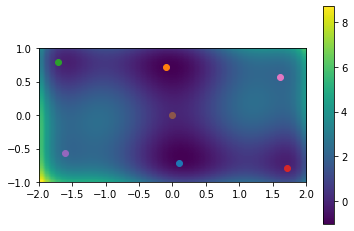

In [419]:
from scipy import optimize
from scipy.optimize import newton
from scipy.optimize import root, fsolve
from scipy.optimize import basinhopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def sixhump(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]
            + (-4 + 4*x[1]**2) * x[1] **2)

x = np.linspace(-2.1, 2)
y = np.linspace(-1.1, 1)
xg, yg = np.meshgrid(x, y)

#x_min = optimize.minimize(sixhump, x0=[0, 0]) # First I tried basic minimize function. But it is too risky to miss 
# the global minima. When the initial guess (x,y) = (0,0) the roots are both 0. And the function value is zero.


#x_min = optimize.minimize(sixhump, x0=[1, 0])
x_range = np.arange(-2,2,0.1)
y_range = np.arange(-1,1,0.1)
#print(x_range)
#print(y_range)
myUniqueList = []
plt.figure()
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1], origin="lower")
plt.colorbar()
for i in x_range:
    for j in y_range:
        x_min = optimize.minimize(sixhump, x0=[i, j],method='BFGS')
       
        myUniqueElement = [(truncate(x_min['x'][0],4)),truncate(x_min['x'][1],4)]
        if myUniqueList.count(myUniqueElement)<1:
            myUniqueList.append(myUniqueElement)
            plt.scatter(x_min.x[0], x_min.x[1])
            print("Extremum values are:",x_min['fun'],"at corresponding x,y points", x_min['x'],"when the initial guess is: ",[i,j],"\n\n")
        #Show the function in 2D
        # And the minimum that we've found:
        #print(x_min.x[0], x_min.x[1],"\n\n")
        #print(x_min['x'],x_min['fun'])
        
plt.show()        
        
        
from scipy.optimize import show_options

#show_options(solver="minimize")



By iterating over the initial guesses, many calculations have been completed and unique solutions have been collected in a list. As we can see from the results, F(x,y)= -1.0316.. is the global minimum of the function. It occurs at two different regions where (x,y)= (0.08984184, -0.71265628) and (-0.08984181  0.71265638). 


And moreover, the 6th result, which x,y and F(x,y) values are very close to zero, corresponds to (0,0) initial guess and F(x,y)=0. 



2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

parameters:
 [14.2894865  18.44848879]
covariance matrix:
 [[ 1.50475549 -0.87419129]
 [-0.87419129  0.92783021]]
A = 14.29 +- 1.23
f = 18.45 +- 0.96
R2 = 0.9313639733061831 
R = 0.965072004208071
Covariance matrix:
 [[1.       0.965072]
 [0.965072 1.      ]]


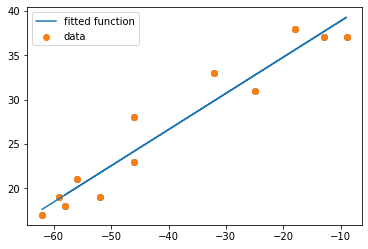

In [420]:
Alaska_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
Alaska_max = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
plt.figure(figsize=(6, 4))
plt.scatter(Alaska_min, Alaska_max)

def f(x,a,b):
    return (a*(x+60))/35 + b

# According to selected 2 points and slope between them 10*(x+60)/35 + 20 is selected as function.

popt, pcov = optimize.curve_fit(f, Alaska_min, Alaska_max,p0=[10,20])

print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
print("A = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("f = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))

plt.scatter(Alaska_min, Alaska_max, label='data')
plt.plot(Alaska_min, f(Alaska_min, popt[0], popt[1]), label='fitted function')
plt.legend(loc='best')


cov = np.cov(Alaska_min, Alaska_max, ddof=2)
b_hat = cov[0, 1] / cov[0, 0]
a_hat = np.mean(Alaska_max - b_hat * Alaska_min)

n = len(Alaska_min)
ssr = np.sum((Alaska_max - (a_hat + b_hat * Alaska_min))**2)

ssr = np.sum((Alaska_max - a_hat - b_hat * Alaska_min)**2)
tss = np.sum((np.mean(Alaska_max) - Alaska_max)**2)

rsq = 1 - ssr / tss

print("R2 =", rsq, "\nR =", np.sqrt(rsq))
print("Covariance matrix:\n", np.corrcoef(Alaska_min,Alaska_max)) # check with the correlation matrix that R is the correlation coefficient

# We can conclude that the fit describes the data well because R is almost 1. Also, Correlation coefficient of 
# Correlation matrix is the same with R as expected for linear regressions.  




3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

sigma values are:  26.362852652928137
chi2_w 0.0072054160279438175
chi2_w1 0.12417999546479687
p-value_w = 1.0
p-value_w1 = 0.9999999999999948


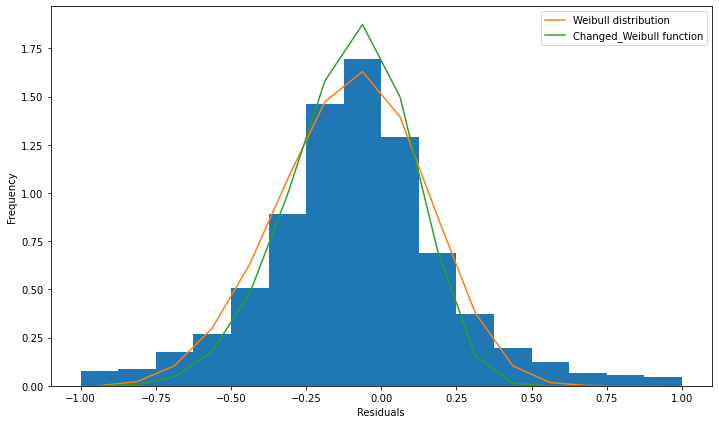

In [421]:
import pickle
from scipy import stats
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
filename = "data/residuals_261.pkl"
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()
#myDict = new_dict[()]
myItem = new_dict.item()
df = pd.DataFrame(myDict)
#print(df)

myRes = df['residuals']

fig, ax = plt.subplots(figsize=(10, 6)) # create the figure and the axes
h, bins, _ = plt.hist(myRes, bins=16, range=(-1, 1), density=True, cumulative=False) # create and plot the histogram
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
fig.tight_layout()

#print(h,bins)
# number of elements in each bin
n_i = int((df.index.stop - 1)/(len(bins)-1))
#print(n_i)

sigma_i = np.sqrt(n_i)
print("sigma values are: ",sigma_i)


ndof = len(bins) - 1
#print("n degrees of freedom =", ndof)
# calculate the chi^2

from scipy.stats import weibull_min

#Weibull distribution
def f(x,k,loc):
    return weibull_min.pdf(x, k, loc) 
    
def f1(x,k,loc):
    
    return 5*((x-loc)**(k-1))*np.exp(-((x-loc)**k))
    
bin_centers = 0.5 * (bins[:-1] + bins[1:])
popt, pcov = optimize.curve_fit(f, bin_centers, h,p0=[2,-1])
popt1, pcov1 = optimize.curve_fit(f1, bin_centers, h,p0=[2,-1])

plt.plot(bin_centers, f(bin_centers, popt[0], popt[1]), label='Weibull distribution')
plt.plot(bin_centers, f1(bin_centers, popt1[0], popt1[1]), label='Changed_Weibull function')
plt.legend(loc='best')


h_weibull = f(bin_centers,2,-1)
h_weibull1 = 5*((x+1)) * np.exp(-((x+1)**2))
# In order to see how p-value changes, I just proposed a bad function which is Weibull multiplied by 2.5.
# Since Weibull distribution is valid only for x>0, and the range is between (-1,1) the function is fitted,
# However, for the loc value smaller than -1, the function that I proposed doesn' t fit as well as Weibull. 

chi2_w = np.sum((h_weibull**2)/(sigma_i**2))
chi2_w1 = np.sum((h_weibull1**2)/(sigma_i**2))
pvalue_w = 1. - stats.chi2.cdf(chi2_w, ndof)
pvalue_w1 = 1. - stats.chi2.cdf(chi2_w1, ndof)

print("chi2_w", chi2_w)
print("chi2_w1", chi2_w1)
print("p-value_w =", pvalue_w)
print("p-value_w1 =", pvalue_w1)




# P value for both Weibull distribution and the Weibull function defined manually is nearly 1, which is a good 
# value representing good fit.





4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

 
 Best-fit values of the parameters are: 
 a = -9.988134 
 b = 12.333023 
 c = 9.384115
Overall Average temperature in Munich between 2008 and 2012 is: 
 9.38409773497604
Predicted value acc. to function, The minimum value of the daily temperature is: 
 -0.604018756032433
Predicted value acc. to function, The maximum value of the daily temperature is: 
 19.3722485503435
 
 Best-fit values of the parameters are: 
 a1 = -9.982182 
 b1 = 1.001444 
 c1 = -5.904152 
 d1 = 9.398124
RSS for f(x): 
 34359.858600 
RSS for g(x): 
 34352.794054 
Test 3-parameter vs 4-parameter:
CL: 0.584 , additional parameter necessary: NO


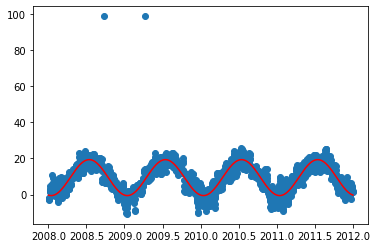

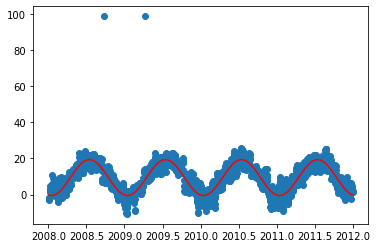

In [534]:
import sympy as sy
from scipy.optimize import fmin
import math
from scipy.stats import f as myF

df = pd.read_csv('data/munich_temperatures_average_with_bad_data.txt', sep=" ", names=['Bad_Data','Temperatures'])
    
def f(t,a,b,c):
    
    return a*np.cos(2*np.pi*t+b)+c

# fit by means of curve_fit
# p0 is a list of the initial guessed values for the parameters
df = df[(2008<df['Bad_Data']) & (df['Bad_Data']<2012)]
#df_range = df_range.drop(['Bad_Data'],axis=1)
#print(df)
popt, pcov = optimize.curve_fit(f, df['Bad_Data'], df['Temperatures'], p0=[1, 1, 1], full_output=False)

plt.scatter(df['Bad_Data'], df['Temperatures'], label='data')
plt.plot(df['Bad_Data'], f(df['Bad_Data'], popt[0], popt[1],popt[2]),'-r', label='fitted function')

print(" \n Best-fit values of the parameters are: \n a = %f \n b = %f \n c = %f" %(popt[0],popt[1],popt[2]))
print("Overall Average temperature in Munich between 2008 and 2012 is: \n",df['Temperatures'].mean())



def new_f(x,a,b,c):
    return -f(x,a,b,c)

# I defined a new function because I would like to find maksimum value by using minimize_scalar. However,
# the result must be reversed sign for the maximum value. It is a tricky way to find max. value as if it is a
# minimum value. 

min_solution = optimize.minimize_scalar(f, method='bounded', bounds=[2008,2012],args=(popt[0],popt[1],popt[2]))
print("Predicted value acc. to function, The minimum value of the daily temperature is: \n",min_solution['fun']) 


max_solution = optimize.minimize_scalar(new_f, bounds = [2008,2012],args=(popt[0],popt[1],popt[2]))
print("Predicted value acc. to function, The maximum value of the daily temperature is: \n",max_solution['fun']*(-1))


# C/B represents the phase shift for the Standard Equation: y = A*sin(B(x−C))+D

# In our case -b/2π is the phase shift which is horizontal shift of a periodic function.

# If we consider the shape of a cosine function is the same, for a better fit, the function can be estimated 

# by the help of b value to shift right or left.




# ------------------------ 2nd Part of the Question ------------------------------


def g(t,a1,b1,c1,d1):
    
    return a1*np.cos(2*np.pi*b1*t+c1)+d1

popt_g, pcov_g = optimize.curve_fit(g, df['Bad_Data'], df['Temperatures'], p0=[1, 1, 1, 1], full_output=False)

plt.figure()
plt.scatter(df['Bad_Data'], df['Temperatures'], label='data')
plt.plot(df['Bad_Data'], g(df['Bad_Data'], popt_g[0], popt_g[1],popt_g[2],popt_g[3]),'-r', label='fitted function')

print(" \n Best-fit values of the parameters are: \n a1 = %f \n b1 = %f \n c1 = %f \n d1 = %f" %(popt_g[0],popt_g[1],popt_g[2],popt_g[3]))




def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - myF.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL
    
f1 = f(df['Bad_Data'],popt[0],popt[1],popt[2])
g1 = g(df['Bad_Data'],popt_g[0],popt_g[1],popt_g[2],popt_g[3])
ssr_1 = np.sum((f1 - df['Temperatures'])**2)
ssr_2 = np.sum((g1-df['Temperatures'])**2)
N = len(df['Temperatures'])
print("RSS for f(x): \n %f " %ssr_1)
print("RSS for g(x): \n %f " %ssr_2)
print("Test 3-parameter vs 4-parameter:")

cl_1_vs_2 = Ftest(ssr_1, ssr_2, 2, 3, N, verbose=True)




